In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l2_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l2_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1533
0
26 28 (1, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 22s 14ms/step - loss: 0.2991 - total_loss: 0.2991 - reg_loss: 0.2991 - val_loss: 0.2607 - val_total_loss: 0.2607 - val_reg_loss: 0.2607
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931439 -0.002329  0.236091    7  2017-04-16
472     2.507290  2.537271 -0.029981  0.232439    1  2017-04-17
473     2.661330  2.673233 -0.011903  0.248641    2  2017-04-18
474     2.754815  2.743153  0.011662  0.204872    3  2017-04-19
475     2.713762  2.714945 -0.001183  0.238567    4  2017-04-20
476     2.999000  2.990623  0.008377  0.152797    5  2017-04-21
477     3.075529  3.079677 -0.004148  0.188925    6  2017-04-22

0.214619086472
best_epochs [5, 7, 8, 6, 10]
(829, 1) 2.67353988457 

2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1533
0
26 28 (2, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080 - val_loss: 0.2774 - val_total_loss: 0.2774 - val_reg_loss: 0.2774
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.934322 -0.005212  0.286745    6  2017-04-15
471     2.507290  2.629917 -0.122627  0.434045    7  2017-04-16
472     2.661330  2.742231 -0.080902  0.360254    1  2017-04-17
473     2.754815  2.745543  0.009272  0.253359    2  2017-04-18
474     2.713762  2.725694 -0.011933  0.293234    3  2017-04-19
475     2.999000  2.997128  0.001872  0.202705    4  2017-04-20
476     3.075529  3.082657 -0.007127  0.225083    5  2017-04-21

0.293632225668
best_epochs [6, 2, 9, 8, 3]
(829, 1) 2.5120816139 

3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1533
0
26 28 (3, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2829 - total_loss: 0.2829 - reg_loss: 0.2829 - val_loss: 0.2700 - val_total_loss: 0.2700 - val_reg_loss: 0.2700
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step -

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.905308  0.023802  0.259404    5  2017-04-14
470     2.507290  2.565592 -0.058302  0.312151    6  2017-04-15
471     2.661330  2.701368 -0.040038  0.417749    7  2017-04-16
472     2.754815  2.779039 -0.024224  0.346067    1  2017-04-17
473     2.713762  2.737831 -0.024069  0.311964    2  2017-04-18
474     2.999000  2.989890  0.009110  0.196027    3  2017-04-19
475     3.075529  3.078562 -0.003033  0.264793    4  2017-04-20

0.301165062339
best_epochs [6, 2, 8, 5, 9]
(829, 1) 2.6445575153 

4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1533
0
26 28 (4, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842 - val_loss: 0.2636 - val_total_loss: 0.2636 - val_reg_loss: 0.2636
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step -

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.906740  0.022370  0.317056    4  2017-04-13
469     2.507290  2.544201 -0.036910  0.276504    5  2017-04-14
470     2.661330  2.691420 -0.030090  0.307940    6  2017-04-15
471     2.754815  2.756554 -0.001739  0.374111    7  2017-04-16
472     2.713762  2.808363 -0.094601  0.360506    1  2017-04-17
473     2.999000  3.008890 -0.009891  0.215239    2  2017-04-18
474     3.075529  3.039010  0.036519  0.257150    3  2017-04-19

0.301215266752
best_epochs [4, 3, 6, 7, 8]
(829, 1) 2.71402714446 

5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1533
0
26 28 (5, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.5862 - total_loss: 0.5862 - reg_loss: 0.5862 - val_loss: 0.2773 - val_total_loss: 0.2773 - val_reg_loss: 0.2773
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.879781  0.049329  0.352737    3  2017-04-12
468     2.507290  2.591487 -0.084197  0.299891    4  2017-04-13
469     2.661330  2.692880 -0.031550  0.287632    5  2017-04-14
470     2.754815  2.746981  0.007833  0.259971    6  2017-04-15
471     2.713762  2.722906 -0.009144  0.398924    7  2017-04-16
472     2.999000  2.992057  0.006943  0.289564    1  2017-04-17
473     3.075529  3.053806  0.021723  0.274188    2  2017-04-18

0.308986558035
best_epochs [4, 7, 6, 9, 8]
(829, 1) 2.75312896435 

6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 15.1334
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1533
0
26 28 (6, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 14ms/step - loss: 0.2870 - total_loss: 0.2870 - reg_loss: 0.2870 - val_loss: 0.2681 - val_total_loss: 0.2681 - val_reg_loss: 0.2681
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.924467  0.004643  0.345776    2  2017-04-11
467     2.507290  2.602766 -0.095476  0.338402    3  2017-04-12
468     2.661330  2.698950 -0.037621  0.318973    4  2017-04-13
469     2.754815  2.761904 -0.007089  0.239107    5  2017-04-14
470     2.713762  2.736693 -0.022931  0.289787    6  2017-04-15
471     2.999000  2.928671  0.070329  0.338130    7  2017-04-16
472     3.075529  3.065621  0.009908  0.349055    1  2017-04-17

0.317033033124
best_epochs [7, 3, 6, 5, 10]
(829, 1) 3.03108568262 

7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 16.3101
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1533
0
26 28 (7, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2844 - total_loss: 0.2844 - reg_loss: 0.2844 - val_loss: 0.2663 - val_total_loss: 0.2663 - val_reg_loss: 0.2663
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.920029  0.009081  0.368954    1  2017-04-10
466     2.507290  2.578278 -0.070988  0.324956    2  2017-04-11
467     2.661330  2.692589 -0.031259  0.330056    3  2017-04-12
468     2.754815  2.762796 -0.007981  0.261584    4  2017-04-13
469     2.713762  2.717322 -0.003560  0.279901    5  2017-04-14
470     2.999000  2.992742  0.006257  0.205083    6  2017-04-15
471     3.075529  3.106015 -0.030486  0.330373    7  2017-04-16

0.300129471049
best_epochs [4, 2, 6, 5, 3]
(829, 1) 3.01739180483 

8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 17.5743
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1533
0
26 28 (8, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2799 - total_loss: 0.2799 - reg_loss: 0.2799 - val_loss: 0.2696 - val_total_loss: 0.2696 - val_reg_loss: 0.2696
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.978947 -0.049837  0.369581    7  2017-04-09
465     2.507290  2.622198 -0.114907  0.350219    1  2017-04-10
466     2.661330  2.700163 -0.038833  0.313323    2  2017-04-11
467     2.754815  2.809131 -0.054316  0.298269    3  2017-04-12
468     2.713762  2.738613 -0.024851  0.296365    4  2017-04-13
469     2.999000  2.944888  0.054112  0.180752    5  2017-04-14
470     3.075529  3.087059 -0.011530  0.233608    6  2017-04-15

0.291731172487
best_epochs [9, 6, 3, 8, 5]
(829, 1) 2.75710407138 

9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 18.8065
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1533
0
26 28 (9, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2882 - total_loss: 0.2882 - reg_loss: 0.2882 - val_loss: 0.3016 - val_total_loss: 0.3016 - val_reg_loss: 0.3016
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.922470  0.006640  0.287849    6  2017-04-08
464     2.507290  2.603060 -0.095770  0.436096    7  2017-04-09
465     2.661330  2.739584 -0.078254  0.389998    1  2017-04-10
466     2.754815  2.764018 -0.009203  0.282251    2  2017-04-11
467     2.713762  2.760970 -0.047209  0.322740    3  2017-04-12
468     2.999000  2.977926  0.021074  0.209291    4  2017-04-13
469     3.075529  3.094780 -0.019251  0.229677    5  2017-04-14

0.308271620303
best_epochs [3, 7, 4, 8, 5]
(829, 1) 2.54603487766 

10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 19.9265
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1533
0
26 28 (10, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1530/1533 [============================>.] - ETA: 0s - loss: 3.0592 - total_loss: 3.0592 - reg_loss: 3.0592Epoch 00001: saving model to testlstm_l2_1/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1533/1533 [=========================

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.926138  0.002972  0.279733    5  2017-04-07
463     2.507290  2.556608 -0.049318  0.290921    6  2017-04-08
464     2.661330  2.701279 -0.039950  0.402555    7  2017-04-09
465     2.754815  2.788386 -0.033571  0.333315    1  2017-04-10
466     2.713762  2.760393 -0.046632  0.302190    2  2017-04-11
467     2.999000  2.989671  0.009329  0.211433    3  2017-04-12
468     3.075529  3.091276 -0.015747  0.263630    4  2017-04-13

0.297682451729
best_epochs [4, 5, 6, 8, 3]
(829, 1) 2.70552473 

11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 21.0577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1533
0
26 28 (11, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2929 - total_loss: 0.2929 - reg_loss: 0.2929 - val_loss: 0.2949 - val_total_loss: 0.2949 - val_reg_loss: 0.2949
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.908712  0.020398  0.325070    4  2017-04-06
462     2.507290  2.578339 -0.071048  0.276119    5  2017-04-07
463     2.661330  2.697688 -0.036359  0.316198    6  2017-04-08
464     2.754815  2.762803 -0.007988  0.390337    7  2017-04-09
465     2.713762  2.811442 -0.097681  0.387011    1  2017-04-10
466     2.999000  3.004181 -0.005181  0.236610    2  2017-04-11
467     3.075529  3.048267  0.027262  0.283001    3  2017-04-12

0.316335288426
best_epochs [7, 4, 3, 9, 6]
(829, 1) 3.05817677126 

12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 22.1151
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1533
0
26 28 (12, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2950 - total_loss: 0.2950 - reg_loss: 0.2950 - val_loss: 0.2861 - val_total_loss: 0.2861 - val_reg_loss: 0.2861
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.895677  0.033433  0.318154    3  2017-04-05
461     2.507290  2.581387 -0.074096  0.296024    4  2017-04-06
462     2.661330  2.664634 -0.003305  0.314958    5  2017-04-07
463     2.754815  2.736699  0.018116  0.256616    6  2017-04-08
464     2.713762  2.743670 -0.029909  0.377097    7  2017-04-09
465     2.999000  2.998666  0.000334  0.251407    1  2017-04-10
466     3.075529  3.058977  0.016552  0.253712    2  2017-04-11

0.295424054976
best_epochs [6, 3, 5, 8, 7]
(829, 1) 2.98937666556 

13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 23.1552
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1533
0
26 28 (13, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2956 - total_loss: 0.2956 - reg_loss: 0.2956 - val_loss: 0.2767 - val_total_loss: 0.2767 - val_reg_loss: 0.2767
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.906377  0.022733  0.346840    2  2017-04-04
460     2.507290  2.566119 -0.058829  0.298570    3  2017-04-05
461     2.661330  2.700699 -0.039369  0.312271    4  2017-04-06
462     2.754815  2.758174 -0.003359  0.262614    5  2017-04-07
463     2.713762  2.742010 -0.028248  0.285857    6  2017-04-08
464     2.999000  2.923200  0.075800  0.327580    7  2017-04-09
465     3.075529  3.039610  0.035919  0.313133    1  2017-04-10

0.306695014594
best_epochs [7, 5, 8, 9, 2]
(829, 1) 3.05414237234 

14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 24.2264
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1533
0
26 28 (14, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.4520 - total_loss: 0.4520 - reg_loss: 0.4520 - val_loss: 0.2893 - val_total_loss: 0.2893 - val_reg_loss: 0.2893
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.897955  0.031155  0.399997    1  2017-04-03
459     2.507290  2.558984 -0.051693  0.286351    2  2017-04-04
460     2.661330  2.674130 -0.012801  0.328912    3  2017-04-05
461     2.754815  2.752244  0.002571  0.276732    4  2017-04-06
462     2.713762  2.750024 -0.036262  0.284349    5  2017-04-07
463     2.999000  2.985620  0.013379  0.195802    6  2017-04-08
464     3.075529  3.065924  0.009605  0.320051    7  2017-04-09

0.298884911947
best_epochs [4, 5, 6, 7, 9]
(829, 1) 3.07659005692 

15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 25.3577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1533
0
26 28 (15, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2864 - total_loss: 0.2864 - reg_loss: 0.2864 - val_loss: 0.2864 - val_total_loss: 0.2864 - val_reg_loss: 0.2864
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.989191 -0.060081  0.364828    7  2017-04-02
458     2.507290  2.623930 -0.116639  0.345956    1  2017-04-03
459     2.661330  2.701486 -0.040156  0.314794    2  2017-04-04
460     2.754815  2.752003  0.002812  0.276172    3  2017-04-05
461     2.713762  2.737568 -0.023807  0.293711    4  2017-04-06
462     2.999000  2.991159  0.007841  0.176535    5  2017-04-07
463     3.075529  3.083318 -0.007788  0.220046    6  2017-04-08

0.284577508279
best_epochs [6, 5, 8, 4, 9]
(829, 1) 2.73284188222 

16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 26.4659
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1533
0
26 28 (16, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2971 - total_loss: 0.2971 - reg_loss: 0.2971 - val_loss: 0.2914 - val_total_loss: 0.2914 - val_reg_loss: 0.2914
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.904097  0.025013  0.292884    6  2017-04-01
457     2.507290  2.621905 -0.114614  0.439876    7  2017-04-02
458     2.661330  2.735548 -0.074219  0.371677    1  2017-04-03
459     2.754815  2.738180  0.016635  0.278232    2  2017-04-04
460     2.713762  2.759628 -0.045866  0.320554    3  2017-04-05
461     2.999000  2.994862  0.004138  0.208156    4  2017-04-06
462     3.075529  3.072663  0.002867  0.224742    5  2017-04-07

0.305160203992
best_epochs [6, 4, 7, 2, 5]
(829, 1) 2.53269880061 

17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 27.6058
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1533
0
26 28 (17, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3005 - total_loss: 0.3005 - reg_loss: 0.3005 - val_loss: 0.3052 - val_total_loss: 0.3052 - val_reg_loss: 0.3052
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.902772  0.026338  0.292977    5  2017-03-31
456     2.507290  2.557482 -0.050191  0.292187    6  2017-04-01
457     2.661330  2.690343 -0.029013  0.409976    7  2017-04-02
458     2.754815  2.783398 -0.028583  0.348946    1  2017-04-03
459     2.713762  2.748272 -0.034511  0.321020    2  2017-04-04
460     2.999000  3.001575 -0.002576  0.218526    3  2017-04-05
461     3.075529  3.053842  0.021687  0.254551    4  2017-04-06

0.305454592049
best_epochs [5, 3, 2, 6, 8]
(829, 1) 2.63704143384 

18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 28.7513
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1533
0
26 28 (18, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2987 - total_loss: 0.2987 - reg_loss: 0.2987 - val_loss: 0.2967 - val_total_loss: 0.2967 - val_reg_loss: 0.2967
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.883498  0.045612  0.336735    4  2017-03-30
455     2.507290  2.547016 -0.039726  0.267320    5  2017-03-31
456     2.661330  2.658795  0.002535  0.321314    6  2017-04-01
457     2.754815  2.744638  0.010177  0.372490    7  2017-04-02
458     2.713762  2.777795 -0.064033  0.364981    1  2017-04-03
459     2.999000  2.952925  0.046075  0.240242    2  2017-04-04
460     3.075529  3.000956  0.074573  0.258977    3  2017-04-05

0.308865673505
best_epochs [4, 3, 6, 5, 2]
(829, 1) 2.7263132502 

19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 29.7986
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1533
0
26 28 (19, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2990 - total_loss: 0.2990 - reg_loss: 0.2990 - val_loss: 0.2859 - val_total_loss: 0.2859 - val_reg_loss: 0.2859
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.863091  0.066019  0.345756    3  2017-03-29
454     2.507290  2.592095 -0.084804  0.323697    4  2017-03-30
455     2.661330  2.678778 -0.017448  0.293638    5  2017-03-31
456     2.754815  2.727457  0.027358  0.277049    6  2017-04-01
457     2.713762  2.731191 -0.017429  0.402374    7  2017-04-02
458     2.999000  2.985671  0.013328  0.264186    1  2017-04-03
459     3.075529  3.042763  0.032766  0.269617    2  2017-04-04

0.310902321455
best_epochs [5, 4, 7, 6, 2]
(829, 1) 2.71520774837 

20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 30.7963
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1533
0
26 28 (20, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3033 - total_loss: 0.3033 - reg_loss: 0.3033 - val_loss: 0.2924 - val_total_loss: 0.2924 - val_reg_loss: 0.2924
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.900743  0.028367  0.358793    2  2017-03-28
453     2.507290  2.562347 -0.055057  0.313731    3  2017-03-29
454     2.661330  2.682348 -0.021018  0.336094    4  2017-03-30
455     2.754815  2.731805  0.023010  0.253235    5  2017-03-31
456     2.713762  2.717068 -0.003306  0.294709    6  2017-04-01
457     2.999000  2.929785  0.069215  0.333565    7  2017-04-02
458     3.075529  3.041184  0.034345  0.294513    1  2017-04-03

0.312091411067
best_epochs [5, 4, 6, 8, 7]
(829, 1) 2.96476579794 

21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 31.7929
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1533
0
26 28 (21, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2960 - total_loss: 0.2960 - reg_loss: 0.2960 - val_loss: 0.2763 - val_total_loss: 0.2763 - val_reg_loss: 0.2763
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.927743  0.001367  0.390672    1  2017-03-27
452     2.507290  2.558001 -0.050711  0.312367    2  2017-03-28
453     2.661330  2.704044 -0.042715  0.339834    3  2017-03-29
454     2.754815  2.776878 -0.022063  0.284618    4  2017-03-30
455     2.713762  2.725600 -0.011839  0.269378    5  2017-03-31
456     2.999000  2.987039  0.011961  0.215962    6  2017-04-01
457     3.075529  3.075883 -0.000353  0.325777    7  2017-04-02

0.305515300721
best_epochs [3, 6, 5, 2, 8]
(829, 1) 3.0661923852 

22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 32.871
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1533
0
26 28 (22, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.2943 - total_loss: 0.2943 - reg_loss: 0.2943 - val_loss: 0.2963 - val_total_loss: 0.2963 - val_reg_loss: 0.2963
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.960162 -0.031052  0.356625    7  2017-03-26
451     2.507290  2.544035 -0.036745  0.326818    1  2017-03-27
452     2.661330  2.661279  0.000051  0.308822    2  2017-03-28
453     2.754815  2.740955  0.013860  0.287044    3  2017-03-29
454     2.713762  2.715616 -0.001854  0.325093    4  2017-03-30
455     2.999000  2.955798  0.043202  0.202681    5  2017-03-31
456     3.075529  3.070527  0.005003  0.222156    6  2017-04-01

0.289891215563
best_epochs [5, 4, 3, 6, 7]
(829, 1) 2.73170123431 

23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 33.9745
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1533
0
26 28 (23, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3000 - total_loss: 0.3000 - reg_loss: 0.3000 - val_loss: 0.2831 - val_total_loss: 0.2831 - val_reg_loss: 0.2831
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.902036  0.027074  0.308974    6  2017-03-25
450     2.507290  2.619904 -0.112614  0.460918    7  2017-03-26
451     2.661330  2.749540 -0.088210  0.376230    1  2017-03-27
452     2.754815  2.737904  0.016910  0.282810    2  2017-03-28
453     2.713762  2.746367 -0.032605  0.318636    3  2017-03-29
454     2.999000  2.973356  0.025644  0.216048    4  2017-03-30
455     3.075529  3.049435  0.026095  0.212009    5  2017-03-31

0.31080341848
best_epochs [5, 4, 3, 7, 8]
(829, 1) 2.48138807875 

24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 35.2084
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1533
0
26 28 (24, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041 - val_loss: 0.2914 - val_total_loss: 0.2914 - val_reg_loss: 0.2914
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.952773 -0.023663  0.295747    5  2017-03-24
449     2.507290  2.535955 -0.028665  0.296669    6  2017-03-25
450     2.661330  2.684128 -0.022798  0.420660    7  2017-03-26
451     2.754815  2.787542 -0.032727  0.346291    1  2017-03-27
452     2.713762  2.740122 -0.026360  0.310940    2  2017-03-28
453     2.999000  2.978131  0.020869  0.219073    3  2017-03-29
454     3.075529  3.037815  0.037714  0.248349    4  2017-03-30

0.305389808602
best_epochs [6, 2, 4, 7, 8]
(829, 1) 2.57912921796 

25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 36.3351
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1533
0
26 28 (25, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041 - val_loss: 0.2895 - val_total_loss: 0.2895 - val_reg_loss: 0.2895
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.899941  0.029169  0.336384    4  2017-03-23
448     2.507290  2.542313 -0.035022  0.286329    5  2017-03-24
449     2.661330  2.654699  0.006631  0.307925    6  2017-03-25
450     2.754815  2.703926  0.050889  0.391008    7  2017-03-26
451     2.713762  2.754033 -0.040272  0.359523    1  2017-03-27
452     2.999000  2.990769  0.008231  0.226879    2  2017-03-28
453     3.075529  3.030420  0.045109  0.281207    3  2017-03-29

0.312750537985
best_epochs [6, 4, 3, 7, 5]
(829, 1) 2.67518258892 

26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 37.3741
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1533
0
26 28 (26, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080 - val_loss: 0.2920 - val_total_loss: 0.2920 - val_reg_loss: 0.2920
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.865498  0.063612  0.375050    3  2017-03-22
447     2.507290  2.585685 -0.078395  0.326055    4  2017-03-23
448     2.661330  2.671044 -0.009714  0.311148    5  2017-03-24
449     2.754815  2.735397  0.019418  0.263634    6  2017-03-25
450     2.713762  2.744817 -0.031055  0.394473    7  2017-03-26
451     2.999000  3.012425 -0.013426  0.264248    1  2017-03-27
452     3.075529  3.049176  0.026353  0.274790    2  2017-03-28

0.315628504633
best_epochs [5, 3, 4, 2, 7]
(829, 1) 2.7314401984 

27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 38.4506
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1533
0
26 28 (27, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 14ms/step - loss: 0.3027 - total_loss: 0.3027 - reg_loss: 0.3027 - val_loss: 0.2891 - val_total_loss: 0.2891 - val_reg_loss: 0.2891
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.871310  0.057800  0.383431    2  2017-03-21
446     2.507290  2.556735 -0.049445  0.299357    3  2017-03-22
447     2.661330  2.684353 -0.023023  0.322279    4  2017-03-23
448     2.754815  2.748800  0.006015  0.271751    5  2017-03-24
449     2.713762  2.722467 -0.008705  0.295009    6  2017-03-25
450     2.999000  2.900571  0.098429  0.344891    7  2017-03-26
451     3.075529  3.046790  0.028739  0.312215    1  2017-03-27

0.318418856839
best_epochs [6, 5, 4, 3, 7]
(829, 1) 2.9794221767 

28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 39.4798
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1533
0
26 28 (28, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025 - val_loss: 0.2848 - val_total_loss: 0.2848 - val_reg_loss: 0.2848
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.974204 -0.045094  0.427612    1  2017-03-20
445     2.507290  2.574381 -0.067091  0.346296    2  2017-03-21
446     2.661330  2.688824 -0.027494  0.324976    3  2017-03-22
447     2.754815  2.718861  0.035954  0.281968    4  2017-03-23
448     2.713762  2.716259 -0.002498  0.297804    5  2017-03-24
449     2.999000  2.937941  0.061059  0.211532    6  2017-03-25
450     3.075529  3.034921  0.040608  0.333526    7  2017-03-26

0.317673344893
best_epochs [2, 7, 5, 6, 1]
(829, 1) 3.08499447258 

29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 40.7934
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1533
0
26 28 (29, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2992 - total_loss: 0.2992 - reg_loss: 0.2992 - val_loss: 0.2730 - val_total_loss: 0.2730 - val_reg_loss: 0.2730
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.979806 -0.050696  0.333873    7  2017-03-19
444     2.507290  2.668241 -0.160951  0.470611    1  2017-03-20
445     2.661330  2.728511 -0.067181  0.349386    2  2017-03-21
446     2.754815  2.758786 -0.003971  0.301979    3  2017-03-22
447     2.713762  2.760987 -0.047225  0.318854    4  2017-03-23
448     2.999000  3.002744 -0.003744  0.194040    5  2017-03-24
449     3.075529  3.103869 -0.028340  0.224240    6  2017-03-25

0.313283298066
best_epochs [4, 6, 3, 1, 7]
(829, 1) 2.79011170071 

30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 41.9859
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1533
0
26 28 (30, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3030 - total_loss: 0.3030 - reg_loss: 0.3030 - val_loss: 0.2897 - val_total_loss: 0.2897 - val_reg_loss: 0.2897
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.920788  0.008322  0.308948    6  2017-03-18
443     2.507290  2.606824 -0.099534  0.423924    7  2017-03-19
444     2.661330  2.735659 -0.074329  0.443292    1  2017-03-20
445     2.754815  2.782832 -0.028017  0.316084    2  2017-03-21
446     2.713762  2.766936 -0.053174  0.319989    3  2017-03-22
447     2.999000  2.995496  0.003503  0.216551    4  2017-03-23
448     3.075529  3.080432 -0.004903  0.234740    5  2017-03-24

0.323361059046
best_epochs [5, 4, 6, 7, 2]
(829, 1) 2.54297159299 

31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 43.2281
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1533
0
26 28 (31, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 21s 13ms/step - loss: 0.3077 - total_loss: 0.3077 - reg_loss: 0.3077 - val_loss: 0.2891 - val_total_loss: 0.2891 - val_reg_loss: 0.2891
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.918907  0.010203  0.298979    5  2017-03-17
442     2.507290  2.550479 -0.043189  0.320087    6  2017-03-18
443     2.661330  2.699597 -0.038268  0.425129    7  2017-03-19
444     2.754815  2.801225 -0.046410  0.424225    1  2017-03-20
445     2.713762  2.767796 -0.054034  0.352483    2  2017-03-21
446     2.999000  2.993505  0.005495  0.223573    3  2017-03-22
447     3.075529  3.056504  0.019025  0.269249    4  2017-03-23

0.330532017685
best_epochs [6, 2, 8, 1, 5]
(829, 1) 2.68780902052 

32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 44.4464
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1533
0
26 28 (32, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1531/1533 [============================>.] - ETA: 0s - loss: 8.5892 - total_loss: 8.5892 - reg_loss: 8.5892Epoch 00001: saving model to testlstm_l2_1/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1533/1533 [=========================

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.854176  0.074934  0.345697    4  2017-03-16
441     2.507290  2.538827 -0.031536  0.274879    5  2017-03-17
442     2.661330  2.660730  0.000599  0.324170    6  2017-03-18
443     2.754815  2.715887  0.038928  0.370618    7  2017-03-19
444     2.713762  2.744937 -0.031175  0.406099    1  2017-03-20
445     2.999000  2.957276  0.041724  0.243380    2  2017-03-21
446     3.075529  3.037621  0.037909  0.292514    3  2017-03-22

0.32247954489
best_epochs [4, 7, 1, 5, 3]
(829, 1) 2.7200416197 

33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 45.5115
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1533
0
26 28 (33, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3079 - total_loss: 0.3079 - reg_loss: 0.3079 - val_loss: 0.3104 - val_total_loss: 0.3104 - val_reg_loss: 0.3104
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.865901  0.063209  0.358875    3  2017-03-15
440     2.507290  2.558630 -0.051339  0.295233    4  2017-03-16
441     2.661330  2.669043 -0.007713  0.308123    5  2017-03-17
442     2.754815  2.734791  0.020024  0.269051    6  2017-03-18
443     2.713762  2.722789 -0.009027  0.399290    7  2017-03-19
444     2.999000  2.926636  0.072364  0.354810    1  2017-03-20
445     3.075529  3.028997  0.046532  0.317436    2  2017-03-21

0.328973931592
best_epochs [6, 5, 3, 7, 4]
(829, 1) 2.72290908048 

34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 46.5688
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1533
0
26 28 (34, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095 - val_loss: 0.2915 - val_total_loss: 0.2915 - val_reg_loss: 0.2915
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.885421  0.043689  0.352029    2  2017-03-14
439     2.507290  2.562521 -0.055231  0.313628    3  2017-03-15
440     2.661330  2.692957 -0.031627  0.319628    4  2017-03-16
441     2.754815  2.744900  0.009914  0.256117    5  2017-03-17
442     2.713762  2.715057 -0.001296  0.300805    6  2017-03-18
443     2.999000  2.941784  0.057215  0.317471    7  2017-03-19
444     3.075529  3.061533  0.013996  0.343260    1  2017-03-20

0.31470564922
best_epochs [5, 3, 2, 6, 7]
(829, 1) 3.00599251925 

35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 47.4733
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1533
0
26 28 (35, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 19s 13ms/step - loss: 0.3053 - total_loss: 0.3053 - reg_loss: 0.3053 - val_loss: 0.2866 - val_total_loss: 0.2866 - val_reg_loss: 0.2866
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.891162  0.037948  0.386580    1  2017-03-13
438     2.507290  2.545719 -0.038428  0.315442    2  2017-03-14
439     2.661330  2.662440 -0.001110  0.313995    3  2017-03-15
440     2.754815  2.764379 -0.009565  0.282399    4  2017-03-16
441     2.713762  2.733522 -0.019761  0.287690    5  2017-03-17
442     2.999000  2.978763  0.020237  0.222317    6  2017-03-18
443     3.075529  3.121968 -0.046439  0.305089    7  2017-03-19

0.301930182851
best_epochs [5, 6, 2, 3, 1]
(829, 1) 3.11494165772 

36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 48.7491
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1533
0
26 28 (36, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3017 - total_loss: 0.3017 - reg_loss: 0.3017 - val_loss: 0.2921 - val_total_loss: 0.2921 - val_reg_loss: 0.2921
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.975557 -0.046447  0.373189    7  2017-03-12
437     2.507290  2.608224 -0.100933  0.336967    1  2017-03-13
438     2.661330  2.696225 -0.034895  0.303002    2  2017-03-14
439     2.754815  2.771939 -0.017124  0.287299    3  2017-03-15
440     2.713762  2.744818 -0.031056  0.303673    4  2017-03-16
441     2.999000  2.993560  0.005440  0.203002    5  2017-03-17
442     3.075529  3.100807 -0.025278  0.237830    6  2017-03-18

0.292137576157
best_epochs [2, 3, 5, 6, 7]
(829, 1) 2.77351109263 

37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 49.8797
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1533
0
26 28 (37, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.2964 - val_total_loss: 0.2964 - val_reg_loss: 0.2964
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.939027 -0.009917  0.300831    6  2017-03-11
436     2.507290  2.624724 -0.117434  0.433023    7  2017-03-12
437     2.661330  2.741939 -0.080610  0.370458    1  2017-03-13
438     2.754815  2.761971 -0.007156  0.294237    2  2017-03-14
439     2.713762  2.738817 -0.025055  0.308542    3  2017-03-15
440     2.999000  2.958838  0.040162  0.215333    4  2017-03-16
441     3.075529  3.069172  0.006357  0.238484    5  2017-03-17

0.308701256203
best_epochs [5, 4, 3, 7, 6]
(829, 1) 2.58165646627 

38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 51.0865
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1533
0
26 28 (38, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125 - val_loss: 0.3141 - val_total_loss: 0.3141 - val_reg_loss: 0.3141
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.909523  0.019587  0.321805    5  2017-03-10
435     2.507290  2.591875 -0.084584  0.318146    6  2017-03-11
436     2.661330  2.738861 -0.077531  0.444225    7  2017-03-12
437     2.754815  2.809418 -0.054604  0.371009    1  2017-03-13
438     2.713762  2.740745 -0.026984  0.320415    2  2017-03-14
439     2.999000  2.976983  0.022017  0.220778    3  2017-03-15
440     3.075529  3.025747  0.049782  0.265196    4  2017-03-16

0.323081888838
best_epochs [2, 5, 4, 6, 7]
(829, 1) 2.70669631971 

39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 52.0488
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1533
0
26 28 (39, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131 - val_loss: 0.2970 - val_total_loss: 0.2970 - val_reg_loss: 0.2970
Epoch 2/100
1533/1533 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.908046  0.021064  0.327260    4  2017-03-09
434     2.507290  2.578685 -0.071395  0.286545    5  2017-03-10
435     2.661330  2.692237 -0.030908  0.319096    6  2017-03-11
436     2.754815  2.809309 -0.054494  0.370083    7  2017-03-12
437     2.713762  2.806527 -0.092765  0.368947    1  2017-03-13
438     2.999000  2.997398  0.001602  0.242634    2  2017-03-14
439     3.075529  3.047465  0.028064  0.263431    3  2017-03-15

0.311142369844
best_epochs [3, 2, 4, 5, 6]
(829, 1) 2.7681994273


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

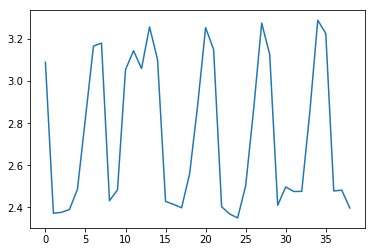

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.933709   
air_0164b9927d20bcc3_2017-04-23              1.480024   
air_0241aa3964b7f861_2017-04-23              2.381386   
air_0328696196e46f18_2017-04-23              2.121302   
air_034a3d5b40d5b1b1_2017-04-23              3.489553   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.915111  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.393052  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.819887  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.341992  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.771311

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l2_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')